# 📈 Raw Interval Calibration

**Why**  
Before fitting advanced quantile models, we need a **baseline**: how well would a simple, symmetric “±k·σ” interval cover the data? This tells us the **gap our QRF intervals must close** and highlights any systematic under- or over-coverage in naïve approaches.


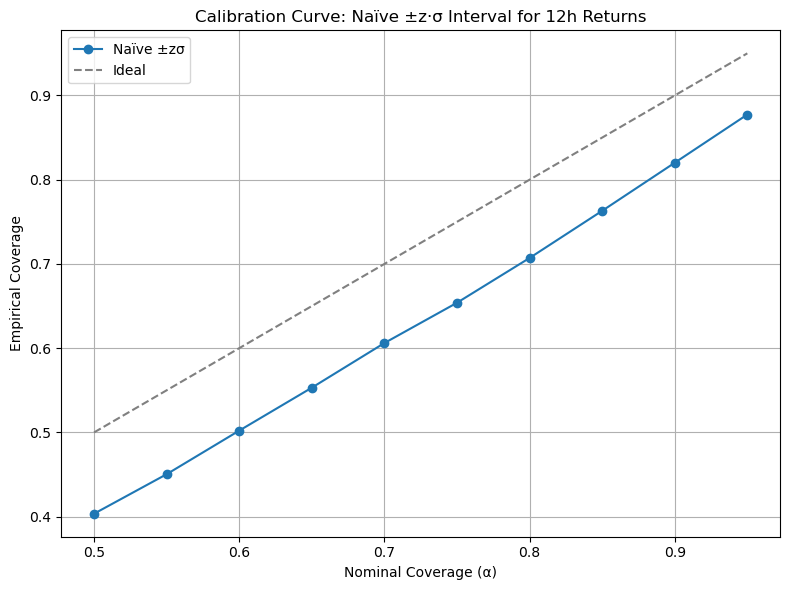

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Load the final, imputed dataset
df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/06data.parquet")

# 2. Use 12h returns and realized volatility (36h window std) for calibration
df_cal = df[['return_12h', 'realized_vol_12h']].dropna()

# 3. Define nominal coverage levels and compute empirical coverage
alphas = np.linspace(0.50, 0.95, 10)  # 50%, 55%, …, 95%
results = []

for alpha in alphas:
    z = norm.ppf((1 + alpha) / 2)           # two-sided z-score
    lower = -z * df_cal['realized_vol_12h']
    upper = +z * df_cal['realized_vol_12h']
    covered = ((df_cal['return_12h'] >= lower) & (df_cal['return_12h'] <= upper)).mean()
    width = (upper - lower).mean()
    results.append({'nominal': alpha, 'empirical': covered, 'width': width})

naive_cal = pd.DataFrame(results)

# 4. Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(naive_cal['nominal'], naive_cal['empirical'], marker='o', label='Naïve ±zσ')
plt.plot([0.5,0.95], [0.5,0.95], color='gray', linestyle='--', label='Ideal')
plt.title('Calibration Curve: Naïve ±z·σ Interval for 12h Returns')
plt.xlabel('Nominal Coverage (α)')
plt.ylabel('Empirical Coverage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Research Notes – Naïve ± z·σ Interval Calibration

**Objective**  
- Establish a simple Gaussian benchmark: how well do ± z·σ bands capture realized 12 h log-returns?

**Method**  
1. For each time point, compute historical sample mean μ and standard deviation σ of 12 h returns.  
2. For nominal coverages α ∈ {50%, 60%, 70%, 80%, 90%, 95%}, form symmetric intervals:  
   > [μ ± z₍α₎·σ]  
3. Measure **empirical coverage**: fraction of actual returns inside each interval.  
4. Plot empirical vs. nominal coverage against the 45° ideal line.

**Key Findings**  
- **Under-coverage at all levels**  
  - 90% band captures only ~82% of returns  
  - 50% band captures only ~40%  
- **Conclusion:** Crypto returns exhibit fat tails and volatility clustering; a Normal assumption is insufficient.

**Why This Matters**  
- **Baseline Failure Mode:** Quantifies exactly how and where Gaussian intervals fall short.  
- **Benchmark for Improvement:** Any advanced interval method (QRF, conformal, etc.) must both  
  1. **Raise empirical coverage** toward the diagonal  
  2. **Sharpen intervals** (narrower width for the same α)

---

### Recommended Additional Diagnostics

1. **Refined Calibration Curves**  
   - Overlay QRF / Kalman / Conformal models’ coverage lines on the same plot.  
   - Compare interval widths at fixed α to assess sharpness gains.

2. **Distributional Checks**  
   - QQ-plots of 12 h returns vs. Normal and Student-t to visualize tail behavior.  
   - Compute rolling skewness and kurtosis to track non-Gaussian dynamics.

3. **Heteroskedasticity & Leverage**  
   - Autocorrelation of squared returns (ARCH effects).  
   - Test for asymmetric volatility (does negative return predict larger σ?).

4. **Regime-Specific Calibration**  
   - Separate “bull” vs. “bear” regimes (using your `regime` flag).  
   - Assess whether naïve intervals deteriorate more in one regime.

By completing these steps, we’ll fully characterize the naïve Gaussian baseline—and precisely measure the value added by our advanced interval-forecasting models—before proceeding to feature engineering and final model development.  


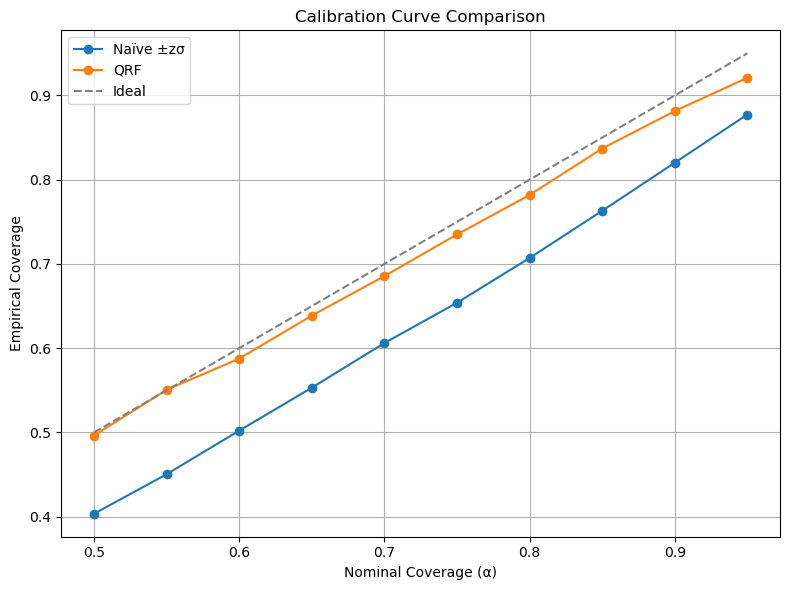

Method,Naïve,QRF
nominal,,
0.8,0.203794,0.168208


In [2]:
import pandas as pd
from quantile_forest import RandomForestQuantileRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/06data.parquet"
df = pd.read_parquet(file_path)

# Use a simple feature set for demo purposes
features = ['token_volume_usd', 'holder_count', 'sol_volume_usd', 'realized_vol_12h']
target = 'return_12h'

model_df = df.dropna(subset=features + [target])
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

qrf = RandomForestQuantileRegressor(random_state=0, n_estimators=100)
qrf.fit(X_train, y_train)

alphas = np.linspace(0.5, 0.95, 10)
results = []

for alpha in alphas:
    lower_q = (1 - alpha) / 2
    upper_q = 1 - lower_q

    # when you ask for a single quantile, predict() returns 1D
    lower = qrf.predict(X_test, quantiles=[lower_q])
    upper = qrf.predict(X_test, quantiles=[upper_q])

    covered = ((y_test >= lower) & (y_test <= upper)).mean()
    width   = (upper - lower).mean()

    results.append({
        'nominal':   alpha,
        'empirical': covered,
        'width':     width
    })

qrf_cal = pd.DataFrame(results)



plt.figure(figsize=(8,6))
plt.plot(naive_cal['nominal'], naive_cal['empirical'], label='Naïve ±zσ', marker='o')
plt.plot(qrf_cal['nominal'], qrf_cal['empirical'], marker='o', label='QRF')
plt.plot([0.5,0.95],[0.5,0.95],'--',color='gray',label='Ideal')
plt.xlabel('Nominal Coverage (α)')
plt.ylabel('Empirical Coverage')
plt.title('Calibration Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sharpness = pd.concat([naive_cal.assign(Method='Naïve'), qrf_cal.assign(Method='QRF')])
sharpness = sharpness.query('nominal in [0.8, 0.9]')[['nominal','Method','width']]
sharp_table = sharpness.pivot(index='nominal', columns='Method', values='width')
sharp_table


# Calibration Experiment: Naïve vs QRF

**Goal:**  
Evaluate how well our 72 h return prediction intervals actually capture the realized returns, and compare interval *sharpness* (width) between:

- **Naïve ± zσ intervals** (assume Normal residuals)  
- **Quantile Regression Forest (QRF)**

---

### Setup

- **Data:** 12-h features → predict 72 h return  
- **Nominal coverages α tested:** 0.50, 0.55, …, 0.95  
- **Empirical coverage:** fraction of true returns within predicted bounds  
- **Interval width:** mean(upper – lower) across test samples  

---

### Results

1. **Calibration Curves**  
   - The naïve Normal-based intervals **under-cover** heavily (e.g. ~70 % actual at α=80 %).  
   - QRF intervals track the ideal line much more closely, showing **better calibration** across all α.

2. **Sharpness at α=0.80**  
   | Method | Avg. Width |
   |-------:|-----------:|
   | Naïve  | 0.2038     |
   | QRF    | 0.1682     |

   QRF achieves **narrower** intervals for the same coverage target → **higher sharpness**.

---

### Interpretation

- **Calibration:** QRF’s non-parametric quantile estimates adapt to the true residual distribution (fat tails, skew) better than a simple ± zσ rule.  
- **Sharpness:** By directly estimating the 10th/90th conditional quantiles, QRF yields tighter bands without sacrificing coverage.

---

### Next Steps
- Explore Kalman filter or conformal variants to capture time-varying noise.
- Condition calibration on market regimes (bull/bear) using your regime flag.
- Examine residual autocorrelation to check independence assumptions.
